In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import string
import random
import numpy as np
import pandas as pd
from pybnesian import GaussianNetwork, LinearGaussianCPD
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap
from scipy.stats import spearmanr  # For statistical analysis


In [8]:
def run_experiment(run_id, num_nodes=6, data_size=100, sample_size=1000, epochs=100, batch_size=8,display_graph=False):
    # ----------------------------- Configuration -----------------------------

    # Set random seeds for reproducibility
    random_seed = run_id  # Use run_id as the seed to get different results in each run
    random.seed(random_seed)
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)

    # Define node labels
    nodes_labels = list(string.ascii_uppercase[:num_nodes])

    # Identify the index and label for node 'F' (assuming 'F' is the target)
    f_index = nodes_labels.index('F') if 'F' in nodes_labels else num_nodes - 1
    f_label = nodes_labels[f_index]

    # --------------------- Graph Generation and Cycle Removal ---------------------

    def generate_random_graph_no_isolated_nodes_no_bidirectional(num_nodes, edge_prob=0.5, forbidden_source=None):
        """
        Generates a random directed graph with no isolated nodes and no bidirectional edges.
        Optionally forbids adding outgoing edges from a specified source node.
        """
        G = nx.DiGraph()
        nodes = list(range(num_nodes))
        G.add_nodes_from(nodes)  # Add all nodes to the graph

        for i in nodes:
            if forbidden_source is not None and i == forbidden_source:
                continue
            for j in nodes:
                if i != j and random.random() < edge_prob:
                    if not G.has_edge(j, i):
                        G.add_edge(i, j)

        # Ensure no isolated nodes by adding at least one edge per node
        for node in nodes:
            if G.degree[node] == 0:
                if node == forbidden_source:
                    possible_targets = [n for n in nodes if n != node and n != forbidden_source]
                    target = random.choice(possible_targets)
                    while G.has_edge(target, node):
                        target = random.choice(possible_targets)
                    G.add_edge(target, node)
                else:
                    possible_targets = [n for n in nodes if n != node]
                    target = random.choice(possible_targets)
                    while G.has_edge(node, target):
                        target = random.choice(possible_targets)
                    G.add_edge(node, target)
        return G

    def remove_cycles_manual(G):
        """
        Removes cycles from a directed graph to make it a DAG by removing one edge from each cycle.
        """
        cycles = list(nx.simple_cycles(G))
        while cycles:
            cycle = cycles[0]
            edge_to_remove = (cycle[-1], cycle[0])
            G.remove_edge(*edge_to_remove)
            cycles = list(nx.simple_cycles(G))
        return G

    # Generate the graph without outgoing edges from 'F'
    G = generate_random_graph_no_isolated_nodes_no_bidirectional(
        num_nodes, edge_prob=0.5, forbidden_source=f_index)

    # Relabel nodes with uppercase letters (A, B, C, ...)
    mapping = {i: letter for i, letter in enumerate(nodes_labels)}
    G = nx.relabel_nodes(G, mapping)

    # Ensure the graph is a DAG
    if not nx.is_directed_acyclic_graph(G):
        G = remove_cycles_manual(G)

    # --------------------- Ensure All Nodes Have Paths to Target ---------------------

    # Compute topological order to ensure target is last
    topo_order = list(nx.topological_sort(G))
    if topo_order[-1] != f_label:
        # Move target to the end
        topo_order.remove(f_label)
        topo_order.append(f_label)
        mapping = {node: idx for idx, node in enumerate(topo_order)}
        G = nx.relabel_nodes(G, mapping, copy=False)
        G = nx.relabel_nodes(G, {v: k for k, v in mapping.items()})  # Reverse mapping

    # Now, ensure every node has a path to the target
    for node in G.nodes:
        if node == f_label:
            continue
        if not nx.has_path(G, node, f_label):
            # Add an edge from node to target
            G.add_edge(node, f_label)

    # Optionally, relabel again if needed to maintain topological order
    if not nx.is_directed_acyclic_graph(G):
        # If adding edges introduced cycles (which it shouldn't), remove them
        G = remove_cycles_manual(G)
        
    # --------------------- Display the Graph ---------------------

    if display_graph:
        plt.figure(figsize=(16, 16))
        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels=True, node_color='lightblue', arrows=True,
                arrowstyle='-|>', arrowsize=12, node_size=500, font_size=12)
        plt.title(f"Graph Structure for Run {run_id}")
        plt.show()
        plt.close()

    # --------------------- Create Gaussian Bayesian Network ---------------------

    nodes = list(G.nodes)
    edges = list(G.edges)
    gbn = GaussianNetwork(nodes, edges)

    # --------------------- Generate Synthetic Data ---------------------

    DATA_SIZE = data_size
    data = {}
    means = {node: 2.0 for node in nodes}
    node_variances = {node: 0.2 for node in nodes}

    # Obtain topological ordering
    topo_order = list(nx.topological_sort(G))

    # Generate data
    for node in topo_order:
        parents = list(G.predecessors(node))
        if not parents:
            variance = node_variances[node]
            data[node] = np.random.normal(means[node], np.sqrt(variance), size=DATA_SIZE)
        else:
            parent_data = sum(data[parent] for parent in parents)
            noise = np.random.normal(0, np.sqrt(node_variances[node]), size=DATA_SIZE)
            data[node] = means[node] + 1.5 * parent_data + noise

    df = pd.DataFrame(data)

    # --------------------- Define and Add CPDs Dynamically ---------------------

    cpds = []
    for node in nodes:
        parents = list(G.predecessors(node))
        if not parents:
            continue
        coefficients = [1.5] * len(parents)
        parameters = [means[node]] + coefficients
        cpd = LinearGaussianCPD(node, parents, parameters, node_variances[node])
        cpds.append(cpd)

    gbn.add_cpds(cpds)

    # --------------------- Fit the Model to Data ---------------------

    try:
        gbn.fit(df)
    except Exception as e:
        print(f"An error occurred during model fitting: {e}")
        return None  # Exit the function if fitting fails

    # --------------------- Sample Data from the Model ---------------------

    try:
        samples = gbn.sample(sample_size)
        # Convert to pandas DataFrame
        sample_df = samples.to_pandas()
    except Exception as e:
        print(f"An error occurred during sampling: {e}")
        return None

    # --------------------- Train Neural Network ---------------------

    # Split data into features and target
    X = sample_df.drop(columns=[f_label]).values
    y = sample_df[f_label].values

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_seed)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Build the neural network model
    model = keras.Sequential([
        layers.Input(shape=(X_train_scaled.shape[1],)),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='linear')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

    # Train the model
    history = model.fit(
        X_train_scaled, y_train, epochs=epochs, batch_size=batch_size,
        validation_split=0.2, verbose=0)

    # Evaluate the model
    test_loss, test_mse = model.evaluate(X_test_scaled, y_test, verbose=0)
    print(f"Test Mean Squared Error: {test_mse:.4f}")

    # Plot the training history
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.title('Model Training History')
    plt.show()

    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)

    # Display the first few predictions and true values
    print("Predictions:", y_pred[:5].flatten())
    print("True Values:", y_test[:5])

    # --------------------- Compute SHAP Values ---------------------

    # Use the first 100 samples from X_test_scaled for SHAP to speed up
    shap_sample = X_test_scaled[:100]
    explainer = shap.KernelExplainer(model.predict, X_train_scaled[:100])
    shap_values = explainer.shap_values(shap_sample, nsamples=100)

    # Calculate mean absolute SHAP values
    mean_shap_values = np.abs(shap_values[0]).mean(axis=0)
    feature_names = sample_df.drop(columns=[f_label]).columns.tolist()

    shap_dict = dict(zip(feature_names, mean_shap_values))

    # --------------------- Compute Average Path Lengths ---------------------

    def compute_average_path_length(G, target=f_label):
        """
        Computes the average length of directed paths from each feature to the target variable.
        """
        avg_path_length_dict = {}
        for node in G.nodes():
            if node == target:
                continue
            try:
                paths = list(nx.all_simple_paths(G, source=node, target=target))
                if paths:
                    avg_length = np.mean([len(path) - 1 for path in paths])
                else:
                    avg_length = np.nan  # Use NaN if no path exists
            except nx.NetworkXNoPath:
                avg_length = np.nan
            avg_path_length_dict[node] = avg_length
        return avg_path_length_dict

    avg_path_lengths = compute_average_path_length(G, target=f_label)

    # --------------------- Collect Results ---------------------

    results = {
        'run_id': run_id,
        'shap_values': shap_dict,
        'path_lengths': avg_path_lengths,
        'test_mse': test_mse,
        'graph': G
    }

    return results


Running experiment 1/30
Test Mean Squared Error: 0.4740


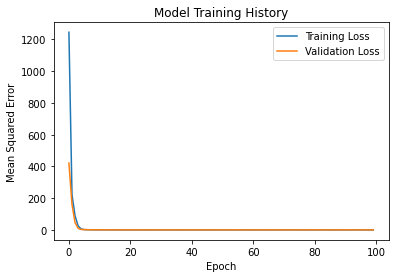

7/7 [==============================] - 0s 1ms/step
Predictions: [50.091038 49.7129   43.23724  46.499874 53.268898]
True Values: [49.93024772 49.46422805 43.85683611 46.98036554 53.56037447]
4/4 [==============================] - 0s 0s/step


  0%|          | 0/100 [00:00<?, ?it/s]

 1/94 [..............................] - ETA: 2s

C:\Users\jpchi\anaconda3\lib\site-packages\shap\explainers\kernel.py:544: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  warnings.warn(


94/94 [==============================] - 0s 1ms/step
Running experiment 2/30
Test Mean Squared Error: 0.3832


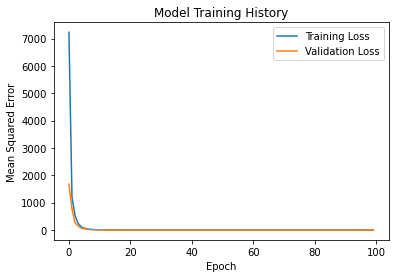

7/7 [==============================] - 0s 1ms/step
Predictions: [106.404434  67.52781   97.60138  108.90749  106.01396 ]
True Values: [106.51101938  68.12909709  98.23876373 108.22886416 106.22952196]
4/4 [==============================] - 0s 0s/step


  0%|          | 0/100 [00:00<?, ?it/s]

 1/94 [..............................] - ETA: 3s

C:\Users\jpchi\anaconda3\lib\site-packages\shap\explainers\kernel.py:544: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  warnings.warn(


94/94 [==============================] - 0s 1ms/step
Running experiment 3/30
Test Mean Squared Error: 0.3399


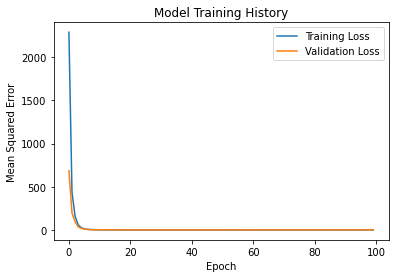

7/7 [==============================] - 0s 1ms/step
Predictions: [56.33893  60.58055  63.536114 55.178337 45.641228]
True Values: [56.34942362 60.19182644 62.65488608 54.76888601 45.74347552]
4/4 [==============================] - 0s 2ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

34/94 [=========>....................] - ETA: 0s

C:\Users\jpchi\anaconda3\lib\site-packages\shap\explainers\kernel.py:544: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  warnings.warn(


94/94 [==============================] - 0s 1ms/step
Running experiment 4/30
Test Mean Squared Error: 0.3971


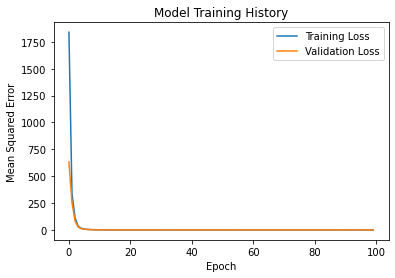

7/7 [==============================] - 0s 3ms/step
Predictions: [54.818558 49.637054 42.121983 58.022762 61.14226 ]
True Values: [54.93795517 50.66121334 42.06298044 58.49069665 61.65772787]
4/4 [==============================] - 0s 0s/step


  0%|          | 0/100 [00:00<?, ?it/s]

59/94 [=================>............] - ETA: 0s

C:\Users\jpchi\anaconda3\lib\site-packages\shap\explainers\kernel.py:544: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  warnings.warn(


94/94 [==============================] - 0s 1ms/step
Running experiment 5/30
Test Mean Squared Error: 0.3371


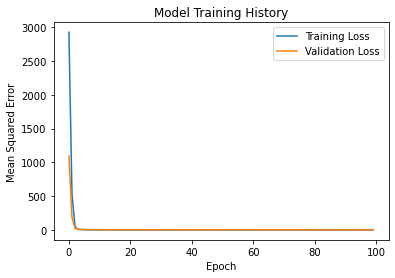

7/7 [==============================] - 0s 1ms/step
Predictions: [78.72386 68.30172 62.18548 61.37616 69.752  ]
True Values: [78.36645181 69.21247613 62.47518094 61.29236363 70.52541121]
4/4 [==============================] - 0s 0s/step


  0%|          | 0/100 [00:00<?, ?it/s]

 1/94 [..............................] - ETA: 2s

C:\Users\jpchi\anaconda3\lib\site-packages\shap\explainers\kernel.py:544: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  warnings.warn(


94/94 [==============================] - 0s 1ms/step
Running experiment 6/30
Test Mean Squared Error: 0.3649


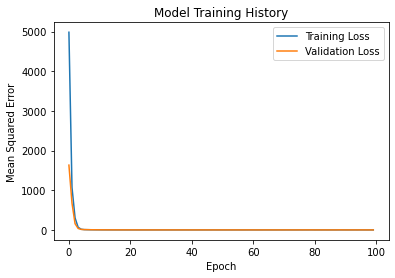

7/7 [==============================] - 0s 0s/step
Predictions: [74.078735 74.006966 58.32875  76.56547  92.47151 ]
True Values: [74.83792346 74.42141458 58.71941742 77.33489727 92.40591648]
4/4 [==============================] - 0s 0s/step


  0%|          | 0/100 [00:00<?, ?it/s]

38/94 [===========>..................] - ETA: 0s

C:\Users\jpchi\anaconda3\lib\site-packages\shap\explainers\kernel.py:544: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  warnings.warn(


94/94 [==============================] - 0s 1ms/step
Running experiment 7/30
Test Mean Squared Error: 0.3814


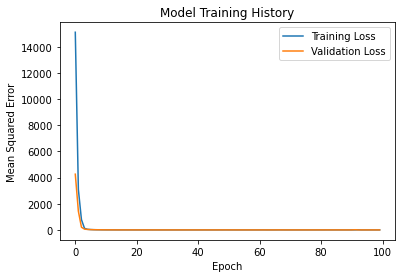

7/7 [==============================] - 0s 0s/step
Predictions: [145.72935 137.10593 151.49559 130.54779 154.77438]
True Values: [145.55051572 137.03904111 151.75891654 131.09532614 154.46603445]
4/4 [==============================] - 0s 0s/step


  0%|          | 0/100 [00:00<?, ?it/s]

 1/94 [..............................] - ETA: 2s

C:\Users\jpchi\anaconda3\lib\site-packages\shap\explainers\kernel.py:544: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  warnings.warn(


94/94 [==============================] - 0s 1ms/step
Running experiment 8/30
Test Mean Squared Error: 0.2847


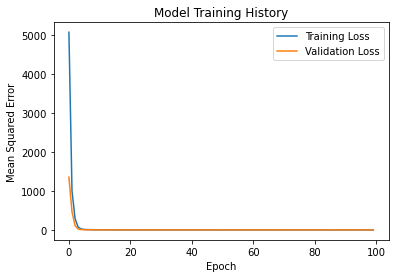

7/7 [==============================] - 0s 1ms/step
Predictions: [ 96.16908  73.02095  69.51246  91.11992 101.28577]
True Values: [ 95.74669703  73.54504237  70.41308699  91.36971138 101.8094581 ]
4/4 [==============================] - 0s 5ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

 1/94 [..............................] - ETA: 3s

C:\Users\jpchi\anaconda3\lib\site-packages\shap\explainers\kernel.py:544: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  warnings.warn(


94/94 [==============================] - 0s 1ms/step
Running experiment 9/30
Test Mean Squared Error: 0.3267


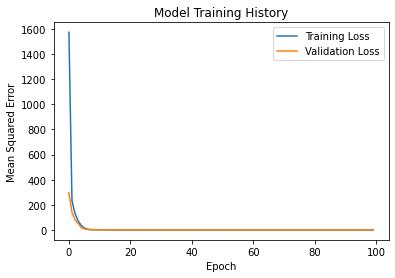

7/7 [==============================] - 0s 0s/step
Predictions: [47.00615  55.625675 43.29449  50.270866 53.459995]
True Values: [47.73837943 56.84644435 43.69986113 50.85955178 54.17224373]
4/4 [==============================] - 0s 2ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

 1/94 [..............................] - ETA: 1s

C:\Users\jpchi\anaconda3\lib\site-packages\shap\explainers\kernel.py:544: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  warnings.warn(


94/94 [==============================] - 0s 1ms/step
Running experiment 10/30
Test Mean Squared Error: 0.3685


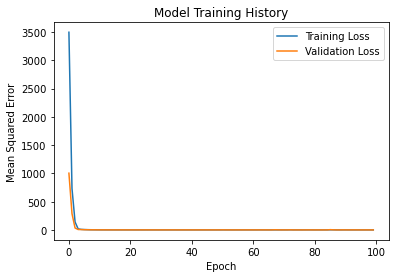

7/7 [==============================] - 0s 0s/step
Predictions: [65.64006  84.164116 66.797134 75.9601   87.95254 ]
True Values: [65.41359598 84.01901696 66.86327261 76.16860352 88.19979067]
4/4 [==============================] - 0s 2ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

 1/94 [..............................] - ETA: 2s

C:\Users\jpchi\anaconda3\lib\site-packages\shap\explainers\kernel.py:544: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  warnings.warn(


1/1 [==============================] - 0s 20ms/step


94/94 [==============================] - 0s 1ms/step
Running experiment 11/30
Test Mean Squared Error: 0.4119


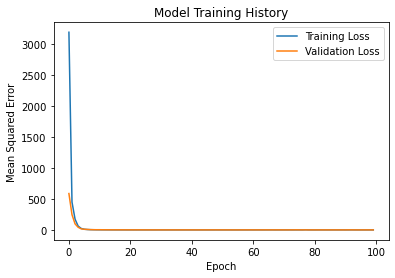

7/7 [==============================] - 0s 0s/step
Predictions: [63.893856 62.502    57.480545 82.280914 79.40681 ]
True Values: [63.57629999 62.00631447 56.76324974 83.55178006 80.33348627]
4/4 [==============================] - 0s 3ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

34/94 [=========>....................] - ETA: 0s

C:\Users\jpchi\anaconda3\lib\site-packages\shap\explainers\kernel.py:544: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  warnings.warn(


94/94 [==============================] - 0s 2ms/step
Running experiment 12/30
Test Mean Squared Error: 0.5651


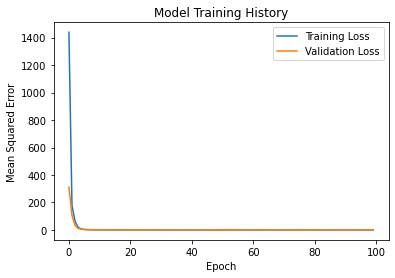

7/7 [==============================] - 0s 0s/step
Predictions: [42.59397  48.16139  53.78665  42.230347 50.792953]
True Values: [42.81814638 47.90219468 53.60872332 43.24003971 51.53072372]
4/4 [==============================] - 0s 0s/step


  0%|          | 0/100 [00:00<?, ?it/s]

 1/94 [..............................] - ETA: 2s

C:\Users\jpchi\anaconda3\lib\site-packages\shap\explainers\kernel.py:544: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  warnings.warn(


94/94 [==============================] - 0s 2ms/step
Running experiment 13/30
Test Mean Squared Error: 0.3072


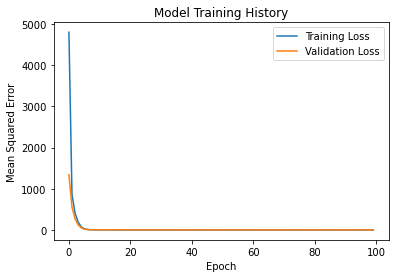

7/7 [==============================] - 0s 0s/step
Predictions: [87.595764 95.72517  71.65929  86.430305 99.354   ]
True Values: [ 87.58493711  96.47863667  71.17374033  86.8566867  100.22996401]
4/4 [==============================] - 0s 3ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

49/94 [==============>...............] - ETA: 0s

C:\Users\jpchi\anaconda3\lib\site-packages\shap\explainers\kernel.py:544: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  warnings.warn(


94/94 [==============================] - 0s 1ms/step
Running experiment 14/30
Test Mean Squared Error: 0.3104


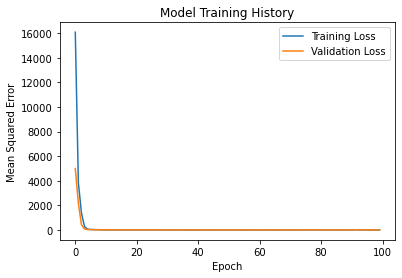

7/7 [==============================] - 0s 3ms/step
Predictions: [150.39346 132.85281 119.39231 146.72847 136.91864]
True Values: [151.09562442 132.41708471 118.07592047 146.64217732 137.53194951]
4/4 [==============================] - 0s 2ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

 1/94 [..............................] - ETA: 1s

C:\Users\jpchi\anaconda3\lib\site-packages\shap\explainers\kernel.py:544: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  warnings.warn(


94/94 [==============================] - 0s 1ms/step
Running experiment 15/30
Test Mean Squared Error: 1.7378


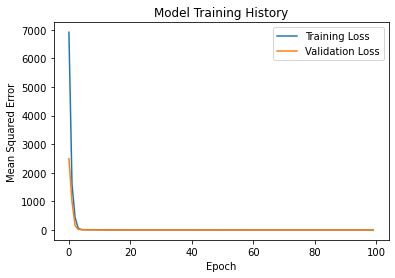

7/7 [==============================] - 0s 3ms/step
Predictions: [ 78.78482  110.969475  69.03652  117.84228   94.426155]
True Values: [ 79.92515494 112.31864476  70.1357015  119.81608964  95.72862723]
4/4 [==============================] - 0s 2ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

32/94 [=========>....................] - ETA: 0s

C:\Users\jpchi\anaconda3\lib\site-packages\shap\explainers\kernel.py:544: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  warnings.warn(


94/94 [==============================] - 0s 1ms/step
Running experiment 16/30
Test Mean Squared Error: 0.2825


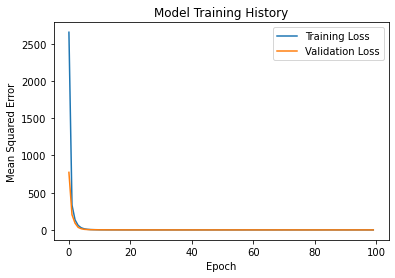

7/7 [==============================] - 0s 2ms/step
Predictions: [43.240593 54.12382  45.836315 50.296913 56.014305]
True Values: [42.86977029 54.32682009 45.18725144 50.57743482 56.54820739]
4/4 [==============================] - 0s 0s/step


  0%|          | 0/100 [00:00<?, ?it/s]

 1/94 [..............................] - ETA: 2s

C:\Users\jpchi\anaconda3\lib\site-packages\shap\explainers\kernel.py:544: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  warnings.warn(


94/94 [==============================] - 0s 1ms/step
Running experiment 17/30
Test Mean Squared Error: 2.1395


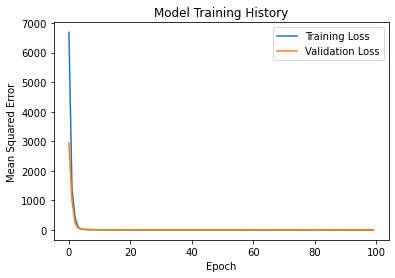

7/7 [==============================] - 0s 0s/step
Predictions: [94.61712 77.41165 77.61878 94.47188 90.81345]
True Values: [93.3465685  76.01395238 75.36442366 93.06999862 89.48837402]
4/4 [==============================] - 0s 3ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

 1/94 [..............................] - ETA: 1s

C:\Users\jpchi\anaconda3\lib\site-packages\shap\explainers\kernel.py:544: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  warnings.warn(


94/94 [==============================] - 0s 2ms/step
Running experiment 18/30
Test Mean Squared Error: 0.2754


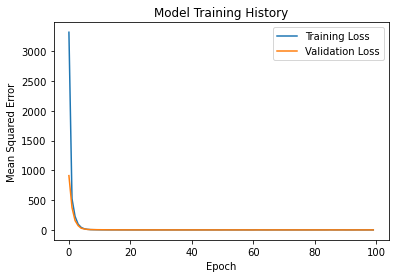

7/7 [==============================] - 0s 0s/step
Predictions: [77.120255 60.70576  66.07269  82.730125 74.36396 ]
True Values: [76.94731216 60.88154799 65.16963315 81.51809304 74.69855679]
4/4 [==============================] - 0s 5ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

38/94 [===========>..................] - ETA: 0s

C:\Users\jpchi\anaconda3\lib\site-packages\shap\explainers\kernel.py:544: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  warnings.warn(


94/94 [==============================] - 0s 1ms/step
Running experiment 19/30
Test Mean Squared Error: 0.6084


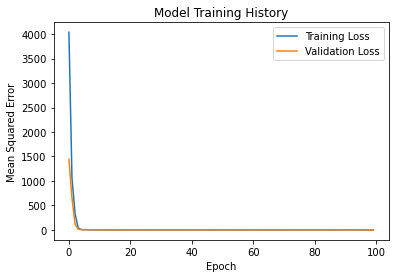

7/7 [==============================] - 0s 3ms/step
Predictions: [66.609886 85.821945 81.65983  85.582146 61.101288]
True Values: [66.67819405 85.06846647 81.51657527 85.45230456 59.9039034 ]
4/4 [==============================] - 0s 0s/step


  0%|          | 0/100 [00:00<?, ?it/s]

 1/94 [..............................] - ETA: 1s

C:\Users\jpchi\anaconda3\lib\site-packages\shap\explainers\kernel.py:544: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  warnings.warn(


94/94 [==============================] - 0s 1ms/step
Running experiment 20/30
Test Mean Squared Error: 1.0400


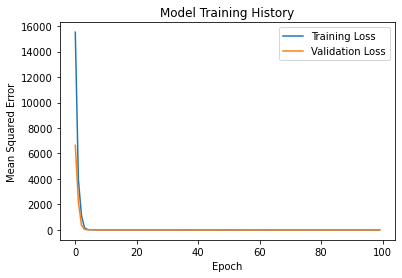

7/7 [==============================] - 0s 3ms/step
Predictions: [167.1109   147.7497   124.298164 129.33995  109.13648 ]
True Values: [167.24075098 147.68981886 125.8223474  130.07046134 111.41647904]
4/4 [==============================] - 0s 2ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

39/94 [===========>..................] - ETA: 0s

C:\Users\jpchi\anaconda3\lib\site-packages\shap\explainers\kernel.py:544: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  warnings.warn(


1/1 [==============================] - 0s 31ms/step


94/94 [==============================] - 0s 1ms/step
Running experiment 21/30
Test Mean Squared Error: 0.9804


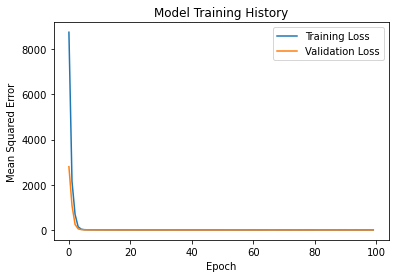

7/7 [==============================] - 0s 2ms/step
Predictions: [ 99.60266  69.42831 115.59708  66.14358 133.32896]
True Values: [ 99.20854325  71.25943667 116.83340678  68.10771897 133.12151412]
4/4 [==============================] - 0s 2ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

39/94 [===========>..................] - ETA: 0s

C:\Users\jpchi\anaconda3\lib\site-packages\shap\explainers\kernel.py:544: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  warnings.warn(


94/94 [==============================] - 0s 810us/step
Running experiment 22/30
Test Mean Squared Error: 0.5402


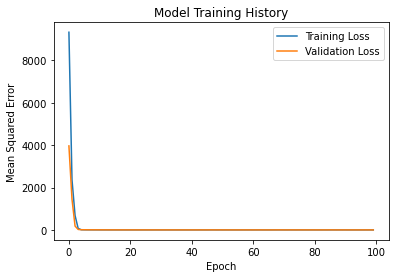

7/7 [==============================] - 0s 2ms/step
Predictions: [125.64682  123.85122   93.834694 119.06981  122.72296 ]
True Values: [126.02060312 123.7368434   92.47758369 118.6875345  122.7110559 ]
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

 1/94 [..............................] - ETA: 2s

C:\Users\jpchi\anaconda3\lib\site-packages\shap\explainers\kernel.py:544: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  warnings.warn(


94/94 [==============================] - 0s 1ms/step


94/94 [==============================] - 0s 2ms/step
Running experiment 23/30
Test Mean Squared Error: 1.6398


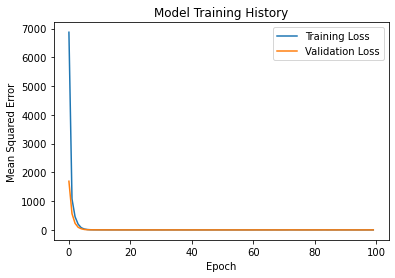

7/7 [==============================] - 0s 3ms/step
Predictions: [129.77414  110.40585  105.92309   91.530075 118.310745]
True Values: [126.9887229  109.39011347 103.97803007  91.99309696 116.33899489]
4/4 [==============================] - 0s 5ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

 1/94 [..............................] - ETA: 1s

C:\Users\jpchi\anaconda3\lib\site-packages\shap\explainers\kernel.py:544: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  warnings.warn(


94/94 [==============================] - 0s 832us/step


94/94 [==============================] - 0s 1ms/step
Running experiment 24/30
Test Mean Squared Error: 0.5732


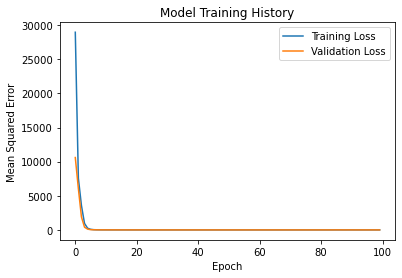

7/7 [==============================] - 0s 3ms/step
Predictions: [238.60362 234.24562 138.60564 187.3382  213.31683]
True Values: [239.6902134  235.16728978 137.36947279 187.7765311  213.49984269]
4/4 [==============================] - 0s 0s/step


  0%|          | 0/100 [00:00<?, ?it/s]

 1/94 [..............................] - ETA: 2s

C:\Users\jpchi\anaconda3\lib\site-packages\shap\explainers\kernel.py:544: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  warnings.warn(


94/94 [==============================] - 0s 1ms/step
Running experiment 25/30
Test Mean Squared Error: 0.3861


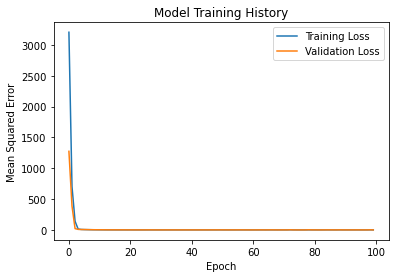

7/7 [==============================] - 0s 2ms/step
Predictions: [70.9239   68.46099  77.6355   81.70505  59.366505]
True Values: [69.62997766 68.77397106 76.45715109 81.75751988 59.33346097]
4/4 [==============================] - 0s 0s/step


  0%|          | 0/100 [00:00<?, ?it/s]

 1/94 [..............................] - ETA: 2s

C:\Users\jpchi\anaconda3\lib\site-packages\shap\explainers\kernel.py:544: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  warnings.warn(


94/94 [==============================] - 0s 1ms/step


94/94 [==============================] - 0s 1ms/step
Running experiment 26/30
Test Mean Squared Error: 0.3355


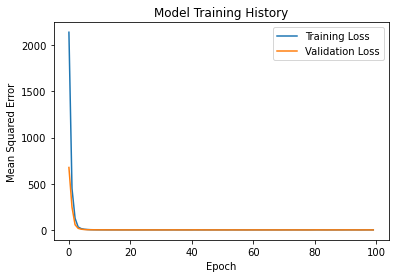

7/7 [==============================] - 0s 2ms/step
Predictions: [49.481266 53.73522  48.95911  57.005634 71.86845 ]
True Values: [50.47938757 53.80600868 49.63111059 56.50557373 70.94397337]
4/4 [==============================] - 0s 0s/step


  0%|          | 0/100 [00:00<?, ?it/s]

 1/94 [..............................] - ETA: 2s

C:\Users\jpchi\anaconda3\lib\site-packages\shap\explainers\kernel.py:544: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  warnings.warn(


94/94 [==============================] - 0s 834us/step
Running experiment 27/30
Test Mean Squared Error: 0.3675


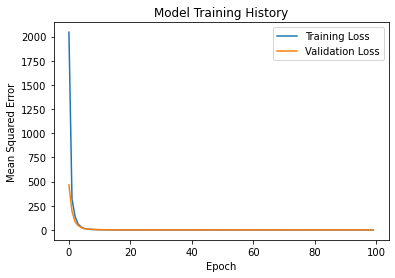

7/7 [==============================] - 0s 2ms/step
Predictions: [50.62503  55.48243  46.034584 44.58352  51.615612]
True Values: [50.32140534 54.97369305 45.65428139 44.37026595 52.15568818]
4/4 [==============================] - 0s 0s/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


C:\Users\jpchi\anaconda3\lib\site-packages\shap\explainers\kernel.py:544: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  warnings.warn(


94/94 [==============================] - 0s 1ms/step
Running experiment 28/30
Test Mean Squared Error: 0.9769


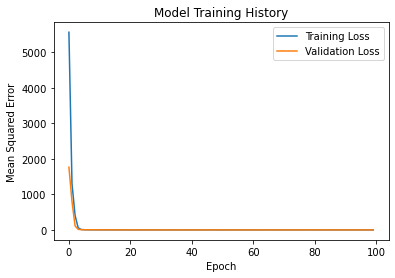

7/7 [==============================] - 0s 1ms/step
Predictions: [98.72512  87.32876  86.03107  83.148094 93.817856]
True Values: [99.74705214 88.93833114 86.2128191  84.57580602 94.44786275]
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

 1/94 [..............................] - ETA: 1s

C:\Users\jpchi\anaconda3\lib\site-packages\shap\explainers\kernel.py:544: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  warnings.warn(


94/94 [==============================] - 0s 897us/step
Running experiment 29/30
Test Mean Squared Error: 0.4383


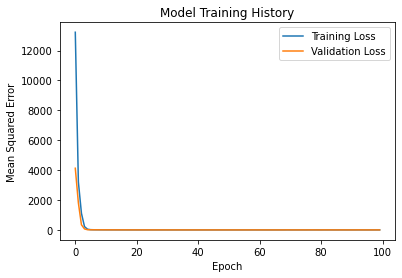

7/7 [==============================] - 0s 3ms/step
Predictions: [134.29008  95.92296 124.72765 128.07774 146.69272]
True Values: [134.08456053  94.84711486 124.48401486 128.32906193 145.92267162]
4/4 [==============================] - 0s 1ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

30/94 [========>.....................] - ETA: 0s

C:\Users\jpchi\anaconda3\lib\site-packages\shap\explainers\kernel.py:544: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  warnings.warn(


94/94 [==============================] - 0s 2ms/step
Running experiment 30/30
Test Mean Squared Error: 2.8702


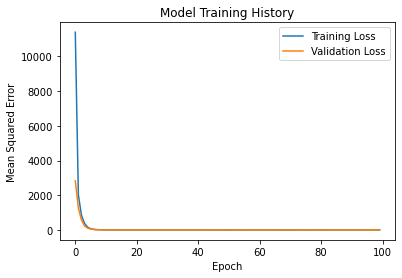

7/7 [==============================] - 0s 3ms/step
Predictions: [131.90764  129.64     114.30236  153.47638  124.126724]
True Values: [133.43679721 131.07233895 115.78787555 154.08313809 125.91861427]
4/4 [==============================] - 0s 3ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


C:\Users\jpchi\anaconda3\lib\site-packages\shap\explainers\kernel.py:544: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  warnings.warn(


94/94 [==============================] - 0s 3ms/step


NameError: name 'math' is not defined

In [9]:

        
# Collect graphs for later visualization
graphs = []
all_results=[]
num_runs=30

for run_id in range(num_runs):
    print(f"Running experiment {run_id + 1}/{num_runs}")
    # Set display_graph=False to prevent immediate display
    result = run_experiment(run_id, display_graph=False)
    if result is not None:
        all_results.append(result)
        # Store the graph for later
        graphs.append({'run_id': run_id, 'graph': result['graph']})




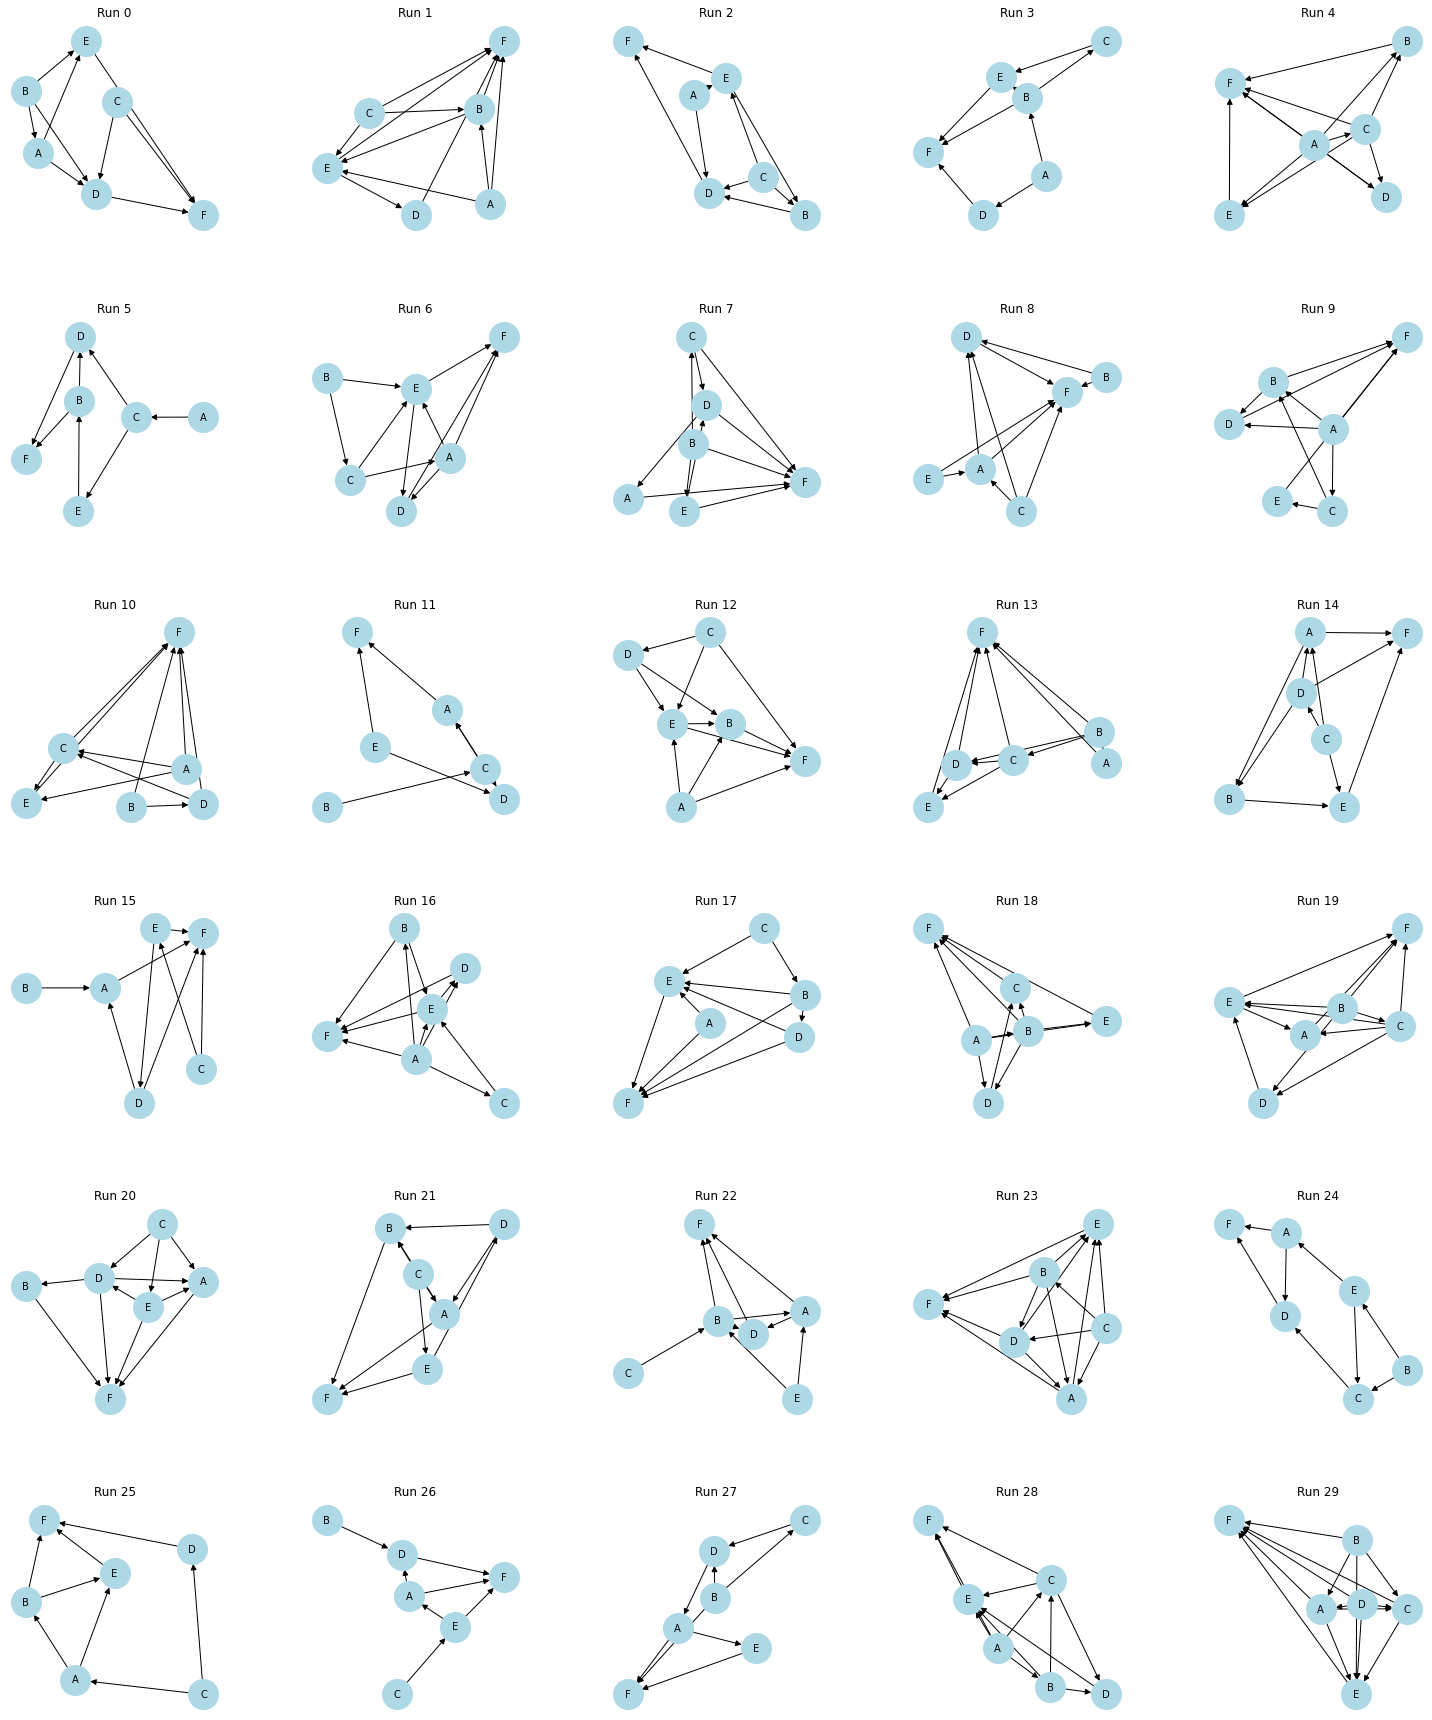

In [18]:
# Now plot all graphs together

import math
import matplotlib.pyplot as plt
import networkx as nx

num_graphs = len(graphs)
ncols = 5  # Number of graphs per row
nrows = math.ceil(num_graphs / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for idx, graph_info in enumerate(graphs):
    G = graph_info['graph']
    ax = axes[idx]
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', arrows=True,
            arrowstyle='-|>', arrowsize=12, node_size=900, font_size=10, ax=ax)
    ax.set_title(f"Run {graph_info['run_id']}")
    ax.axis('off')  # Optional: Turn off the axis

# Hide any unused subplots
for idx in range(len(graphs), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()


In [19]:
# Prepare data for analysis
data_list = []
for res in all_results:
    shap_values = res['shap_values']
    path_lengths = res['path_lengths']
    for feature in shap_values.keys():
        data_list.append({
            'run_id': res['run_id'],
            'feature': feature,
            'shap_value': shap_values[feature],
            'path_length': path_lengths.get(feature, np.nan),
            'test_mse': res['test_mse']
        })

results_df = pd.DataFrame(data_list)
print(results_df )

     run_id feature  shap_value  path_length  test_mse
0         0       C    0.565567          1.5  0.473954
1         0       B    0.700625          2.5  0.473954
2         0       A    0.315138          2.0  0.473954
3         0       E    1.946526          1.0  0.473954
4         0       D    2.076051          1.0  0.473954
..      ...     ...         ...          ...       ...
145      29       D    0.924972          2.5  2.870188
146      29       B    0.416956          2.5  2.870188
147      29       A    1.165133          2.0  2.870188
148      29       C    2.739263          1.5  2.870188
149      29       E    6.928534          1.0  2.870188

[150 rows x 5 columns]


In [20]:
# Remove entries where path length is NaN (i.e., no path to target)
valid_results_df = results_df.dropna(subset=['path_length'])
print(valid_results_df)

# Calculate Spearman correlation for each run
correlations = []
for run_id, group in valid_results_df.groupby('run_id'):
    corr, _ = spearmanr(group['shap_value'], group['path_length'])
    correlations.append({'run_id': run_id, 'spearman_corr': corr})

correlations_df = pd.DataFrame(correlations)

# Average correlation across all runs
average_corr = correlations_df['spearman_corr'].mean()
print(f"Average Spearman correlation between SHAP values and path lengths over {num_runs} runs: {average_corr:.4f}")



     run_id feature  shap_value  path_length  test_mse
0         0       C    0.565567          1.5  0.473954
1         0       B    0.700625          2.5  0.473954
2         0       A    0.315138          2.0  0.473954
3         0       E    1.946526          1.0  0.473954
4         0       D    2.076051          1.0  0.473954
..      ...     ...         ...          ...       ...
145      29       D    0.924972          2.5  2.870188
146      29       B    0.416956          2.5  2.870188
147      29       A    1.165133          2.0  2.870188
148      29       C    2.739263          1.5  2.870188
149      29       E    6.928534          1.0  2.870188

[150 rows x 5 columns]
Average Spearman correlation between SHAP values and path lengths over 30 runs: -0.8144


In [8]:
min_mse = results_df['test_mse'].min()
max_mse = results_df['test_mse'].max()

print("Minimum Mean Squared Error:", min_mse)
print("Maximum Mean Squared Error:", max_mse)


Minimum Mean Squared Error: 0.21471896767616272
Maximum Mean Squared Error: 1.3762856721878052


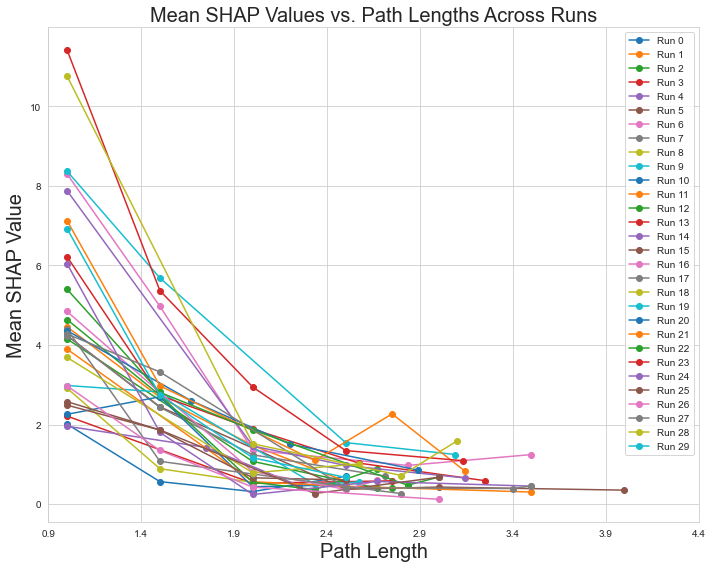

In [40]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

for run_id in run_ids:
    run_data = valid_results_df[valid_results_df['run_id'] == run_id]
    path_shap = run_data.groupby('path_length')['shap_value'].mean().reset_index()
    plt.plot(path_shap['path_length'], path_shap['shap_value'], marker='o', label=f'Run {run_id}')

plt.title('Mean SHAP Values vs. Path Lengths Across Runs',fontsize=20)
plt.xlabel('Path Length',fontsize=20)
plt.ylabel('Mean SHAP Value',fontsize=20)
plt.legend()

# Set x-axis limits to range from 0.9 to 4
plt.xlim(0.9, 4)

# Set x-axis ticks at intervals of 0.5
x_ticks = np.arange(0.9, 4.5, 0.5)  # 4.5 ensures that 4.0 is included
plt.xticks(x_ticks)

plt.tight_layout()
plt.show()
